# Test of topological clustering algorithm

In [1]:
import tensorflow as tf
print(f"Tensorflow version : {tf.__version__}")

Tensorflow version : 2.2.0-rc1


In [2]:
from ipynb.fs.full.clustering import *

Tensorflow version : 2.2.0-rc1


## Create mock data

In [3]:
TSEED = tf.constant(1000., tf.float32)
TNEIGHBOR = tf.constant(100., tf.float32)
TCELL = tf.constant(50., tf.float32)

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
X = np.vstack((np.random.multivariate_normal(mean=[2+2,3+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[2+2,7+2], cov=[[0.7,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[8+2,4+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[15,15], cov=[[1,0],[0,1]], size=15000)))
A = plt.hist2d(X[:,0], X[:,1], bins=20, range=[[0, 20], [0, 20]])[0]
# plt.imshow(A)
# B = A[..., np.newaxis]
A[:2,6] = 1.5*TNEIGHBOR
A[0,7:9] = 1.5*TCELL
A[1,5] = 0
A[3,16] = 20*TSEED

B = np.stack((A,0.5*A), axis=-1).astype(np.float32)
np.shape(B)

(20, 20, 2)

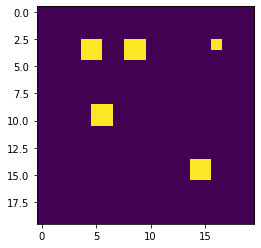

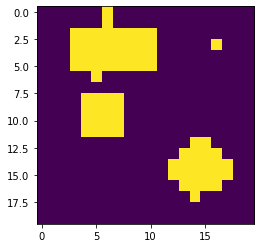

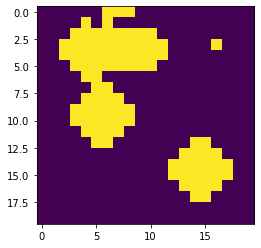

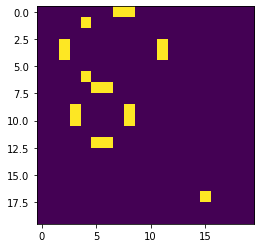

In [5]:
plt.imshow(A > TSEED)
plt.show()
plt.imshow(A > TNEIGHBOR)
plt.show()
plt.imshow(A > TCELL)
plt.show()
plt.imshow((A > TCELL) & (A <= TNEIGHBOR))
plt.show()

In [9]:
# good values to test if recursive function works
d = {'image': tf.expand_dims(tf.constant(B), axis=0)}
# ,
#      'tseed': tf.constant([[1000.]], tf.float32)}
#                 'tneighbour': tf.constant([[100.]], tf.float32),
#                 'tcell': tf.constant([[50.]], tf.float32),
#                 'tenergy': tf.constant([[15e3]]),
#                 'tnum': tf.constant([[3]]),
#                 'tlocmax': tf.constant([[100]])}}

dataset = tf.data.Dataset.from_tensor_slices(d)
# for i in dataset:
#     print(i['tseed'].shape)

In [10]:
mapped = dataset.map(cluster_maker)

In [8]:
for output in mapped.take(1):
    output
    print(tf.shape(output['proto']))

tf.Tensor([126   4], shape=(2,), dtype=int32)


In [9]:
# output = cluster_maker({'image': tf.constant(B)})

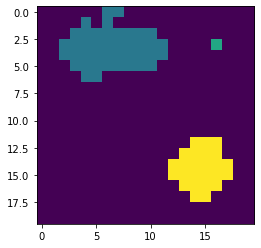

In [10]:
A = output['proto'].numpy()
# print(A)
# A = A[...,1:]
A1 = A[A[...,3] == 0][...,:3]
A2 = A[A[...,3] == 1][...,:3]
# A1 = np.unique(A1, axis=0)
# A2 = np.unique(A2, axis=0)
# print(A1)

sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[20,20])
A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(A1_dense)

In [11]:
sp = tf.SparseTensor(A2[...,1:3], A2[...,0], dense_shape=[HEIGHT,WIDTH])
A2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(A2_dense)

NameError: name 'HEIGHT' is not defined

In [ ]:
# output2['cluster']

In [ ]:
# output = cluster_maker({'image': B})
output2 = cluster_splitter(output)
# output2

In [ ]:
scalar_features(output2)

In [ ]:
C = output2['cluster'].numpy()
# plt.
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
C1 = C1[C1[...,0] == 1]
# C1 = np.unique(C1, axis=0)
# C2 = np.unique(C2, axis=0)
# print(A1)

sp = tf.SparseTensor(C1[...,1:3], C1[...,0], dense_shape=[HEIGHT,WIDTH])
C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C1_dense)

In [ ]:
C = output2['cluster'].numpy()
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
# A1 = np.unique(A1, axis=0)
# A2 = np.unique(A2, axis=0)
# print(A1)

sp = tf.SparseTensor(C1[...,1:3], C1[...,0], dense_shape=[HEIGHT,WIDTH])
C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C1_dense)

In [ ]:
sp = tf.SparseTensor(C2[...,1:3], C2[...,0], dense_shape=[HEIGHT,WIDTH])
C2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C2_dense)

## Unit testing

In [ ]:
def test_sorting():
    # arrange
    image = tf.constant([[[3., 2.], [6., 1.]], [[5., 8.], [7., 4.]]])
    TSEED = 4.
    seed_list = tf.where(tf.math.greater(image, TSEED))
    seed_len = 4
    
    # act
    sorted_seedlist = sorting(seed_list, seed_len, image)
    
    # assert
    assert tf.equal(sorted_seedlist, tf.constant([[1,0,1], [1,1,0], [0,1,0], [1,0,0]], tf.int64)).numpy().all()

In [ ]:
def test_neighbors():
    # arrange
    index = tf.constant([0,0,0], tf.int64)
    seed_list = tf.constant([[1,0,0], [1,1,0], [1,2,0]], tf.int64)
    
    # act
    neigh = neighbors(index, seed_list)
    
    # assert
    assert tf.equal(neigh, tf.constant([[0,0,1], [0,1,0]], tf.int64)).numpy().all()

In [ ]:
test_neighbors()
# test_sorting()

In [ ]:
tf.shape([[1,2], [4,5]])[0].numpy()

In [ ]:
a = tf.constant([6, 5, 4, 3, 2, 1])
c = lambda a: tf.not_equal(tf.size(a), 0)
def b(a): tf.print(a); return [tf.strided_slice(a, [0], [-1], [1])]
r = tf.while_loop(c, b, [a])

In [ ]:
tf.constant([[1000.]], tf.float32)